## Setup

### Project setup

In [142]:
if run_init:
    %pip install -U pip
    !if  [ ! -d "deep-learning-project" ] ; then git clone https://github.com/albertsgarde/deep-learning-project.git; fi
    !cd deep-learning-project && git reset --hard && git pull
    !source deep-learning-project/setup.sh deep-learning-project
    import os
    os.chdir("deep-learning-project/deep-learning")
run_init = False

In [143]:
run_init = True

In [144]:
run_init = False

### Imports

In [145]:
import matplotlib.pyplot as plt

import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nn_func
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import IPython.display as display

import audio_samples_py as aus

import utils.plots as plots
import utils.criterion as chord_criterion
import utils.utils as utils

### Device setup

In [146]:
device, use_cuda = utils.setup_device(use_cuda_if_possible = True)

Running GPU.


## Data

In [147]:
SAMPLE_LENGTH = 1024
BATCH_SIZE = 64
SEED = 2 # Generates different data if changed. Useful to ensure that a result isn't a fluke.

possible_chord_types = [i for i in range(aus.num_chord_types())]
octave_parameters = aus.OctaveParameters(add_root_octave_probability=0.5,
        add_other_octave_probability=0.3)
parameters = aus.DataParameters(num_samples=SAMPLE_LENGTH, octave_parameters=octave_parameters, min_frequency=50, max_frequency=2000, min_frequency_std_dev=0.5, max_frequency_std_dev=3., possible_chord_types=possible_chord_types) \
    .add_sine(probability=0.5, amplitude_range=(0.1,0.2)) \
    .add_saw(probability=0.5, amplitude_range=(0.1, 0.2)) \
    .add_pulse(probability=0.5, amplitude_range=(0.1, 0.2), duty_cycle_range=(0.1, 0.9)) \
    .add_triangle(probability=0.5, amplitude_range=(0.1, 0.2)) \
    .add_noise(probability=1, amplitude_range=(0.001, 0.04)) \
    .apply_distortion(probability=0.5, power_range=(0.1, 20)) \
    .apply_normalization(probability=1)

### Generation

In [148]:
def label_to_target(label: aus.DataPointLabel):
    
    target = np.zeros(aus.num_chord_types() + 12, dtype=np.float32)
    target[label.chord_type()] = 1
    target[aus.num_chord_types() + label.note()] = 1
    return target

training_parameters, training_loader, validation_parameters, validation_loader = utils.init_synth_data(parameters, label_to_target, SEED, BATCH_SIZE)
rw_training_loader, rw_validation_loader = utils.init_rw_data("data/short_guitar_samples/", label_to_target, 0.0, BATCH_SIZE)

## Neural Network

In [149]:
net = torch.jit.load("./model.pt")

if use_cuda:
    net.cuda()

## Evaluation

In [150]:
data_header = ["Tone", "Type", "Out Tone", "Out Type", "Acc.Type", "Acc.Tone", "Acc"]

tone_names = ["A","Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"]

def build_data_row(label: aus.DataPointLabel, output, target):
    if label.frequencies():
        frequencies = label.frequencies()
        min_frequency = min(frequencies)
        max_frequency = max(frequencies)
    else:
        min_frequency = None
        max_frequency = None
    
    output_chord_type = np.argmax(output[:aus.num_chord_types()])
    output_chord_tone = np.argmax(output[aus.num_chord_types():])
    accurate_chord_type = output_chord_type == label.chord_type()
    accurate_chord_tone = output_chord_tone == label.note()
    accurate = accurate_chord_type and accurate_chord_tone
    

    return [tone_names[label.note()], label.chord_type_name(), tone_names[output_chord_tone], aus.chord_type_name(output_chord_type), accurate_chord_type, accurate_chord_tone, accurate]


In [151]:
criterion = chord_criterion.ChordToneLoss(aus.num_chord_types())  

In [152]:
NUM_DATA_POINTS = 10_000
PRINT_PROGRESS_EVERY = 100
OUTPUT_PATH = "eval_data.csv"

data = []

net.eval()
def eval():
    for batch_signal, batch_fft, batch_target, batch_labels in rw_training_loader:
        batch_signal = utils.to_torch(batch_signal)
        batch_fft = utils.to_torch(batch_fft)
        batch_target = utils.to_torch(batch_target)
        batch_output = net(batch_signal, batch_fft)

        for i in range(batch_signal.shape[0]):

            label = batch_labels[i]
            target = utils.to_numpy(batch_target[i,:])
            output = utils.to_numpy(batch_output[i,:])
            
            data_row = build_data_row(label, output, target) 
            data.append(data_row)

            print(f"Processed: {len(data)}", end="\r")
            if len(data) >= NUM_DATA_POINTS:
                break
        if len(data) >= NUM_DATA_POINTS:
            break
eval()


In [153]:
import csv

with open(OUTPUT_PATH, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(data_header)
    writer.writerows(data)


  Tone   Type Out Tone Out Type  Acc.Type  Acc.Tone    Acc    Chord Out Chord
0    F  Major        F    Major      True      True   True  F,Major   F,Major
1    E  Minor        E    Minor      True      True   True  E,Minor   E,Minor
2    E  Minor        E    Major     False      True  False  E,Minor   E,Major
3    A  Major        A    Major      True      True   True  A,Major   A,Major
4    B  Minor        B    Minor      True      True   True  B,Minor   B,Minor


<AxesSubplot:xlabel='Out Chord', ylabel='Chord'>

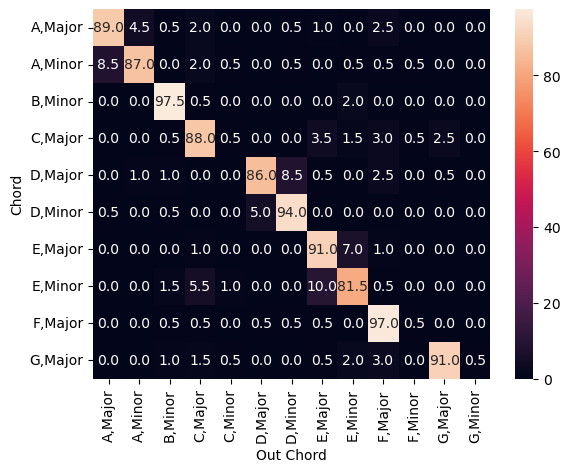

In [159]:
import seaborn as sns
import pandas as pd
import matplotlib as plt

data = pd.read_csv("eval_data.csv")

chord_count_data = data.copy(deep=True)
chord_count_data["Chord"] = chord_count_data["Tone"] + "," + chord_count_data["Type"]
chord_count_data["Out Chord"] = chord_count_data["Out Tone"] + "," + chord_count_data["Out Type"]

print(chord_count_data.head())

chord_count_data = chord_count_data[["Chord", "Out Chord"]] \
    .pipe(pd.pivot_table, index=["Chord"], columns=["Out Chord"], aggfunc=len, fill_value=0)
    
chord_count_data = chord_count_data.div(chord_count_data.sum(axis=1)/100, axis="index")

sns.heatmap(chord_count_data, annot=True, fmt=".1f")
